In [1]:
import math
import collections

import pandas as pd

from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import *

import params
from utils.sequence_data import generator_for_binary_classifier, generator_to_samples_and_targets
from utils.metrics import print_report_for_binary_classfier
from utils.preprocessing import probs_to_binary_classes
from utils.hyperparams import hyperparams_search
from utils.plot import plot_train_validation_metric

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("../datasets/data_for_models/dataset_1996-01-01_2019-08-22.csv",
                           header=0, parse_dates=[0], index_col=0)
input_shape = (None, dataset.shape[-1])
#params for generator
label_index = len(dataset.columns) -1

In [3]:
train_max_idx = math.ceil(len(dataset)*params.TRAIN_RATIO)
val_max_idx = math.ceil(len(dataset)*(params.TRAIN_RATIO+params.VAL_RATIO))

# 1 step = 1 batche of samples 
train_steps = (train_max_idx+1 -params.LOOKBACK) // params.BATCH_SIZE
val_steps =  (val_max_idx - train_max_idx - params.LOOKBACK) // params.BATCH_SIZE
test_steps = (len(dataset) - val_max_idx - params.LOOKBACK) // params.BATCH_SIZE

In [4]:
#init generator_for_binary_classifiers
train_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=0,
                      max_index=train_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)



val_gen = generator_for_binary_classifier(dataset.to_numpy(),
                    label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=train_max_idx+1,
                      max_index=val_max_idx,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)

test_gen = generator_for_binary_classifier(dataset.to_numpy(),
                      label_index=label_index,
                      lookback=params.LOOKBACK,
                      delay=params.DELAY,
                      min_index=val_max_idx+1,
                      max_index=None,
                      shuffle=False,
                      step=params.STEP, 
                      batch_size=params.BATCH_SIZE,
                      interval_label=True)

In [5]:
def lstm_model(hidden_unit, n_layer, l2_weight, input_shape):
    model = Sequential()
    is_return_sequences = True if n_layer>=2 else False
    
    # first layer
    model.add(LSTM(hidden_unit, 
                   input_shape=input_shape,
                   kernel_regularizer=regularizers.l2(l2_weight),
                   recurrent_regularizer=regularizers.l2(l2_weight),
                   return_sequences=is_return_sequences))
    
    # intermediate layers
    if n_layer >= 3:
        for _ in range(n_layer-2):
            model.add(LSTM(hidden_unit,
                           kernel_regularizer=regularizers.l2(l2_weight),
                           recurrent_regularizer=regularizers.l2(l2_weight),
                           return_sequences=is_return_sequences))

    
    # last layer
    if n_layer >= 2:
        model.add(LSTM(hidden_unit,
                       recurrent_regularizer=regularizers.l2(l2_weight),
                       kernel_regularizer=regularizers.l2(l2_weight)))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [7]:
best_params = hyperparams_search(model_func=lstm_model, 
                                 input_shape=input_shape,
                                 train_steps=train_steps, 
                                 val_steps=val_steps, 
                                 train_gen=train_gen, 
                                 val_gen=val_gen, 
                                 num_epoch=1000,
                                 hidden_units=[32,64], 
                                 n_layers=[1,2], 
                                 l2_weights=[0,0.0005,0.0015],
                                 is_verbose=1)
print(best_params)

Epoch 1/2
63/63 [==============================] - 2s 25ms/step - loss: 0.5714 - acc: 0.7378 - val_loss: 0.2666 - val_acc: 0.9868
Epoch 2/2
63/63 [==============================] - 1s 16ms/step - loss: 0.5660 - acc: 0.7517 - val_loss: 0.2577 - val_acc: 0.9868
Epoch 1/2
63/63 [==============================] - 2s 29ms/step - loss: 0.5858 - acc: 0.7535 - val_loss: 0.3391 - val_acc: 0.9868
Epoch 2/2
63/63 [==============================] - 1s 22ms/step - loss: 0.5663 - acc: 0.7525 - val_loss: 0.3099 - val_acc: 0.9868
Epoch 1/2
63/63 [==============================] - 3s 48ms/step - loss: 0.6052 - acc: 0.7386 - val_loss: 0.3867 - val_acc: 0.9868
Epoch 2/2
63/63 [==============================] - 2s 31ms/step - loss: 0.5694 - acc: 0.7552 - val_loss: 0.3754 - val_acc: 0.9868
Epoch 1/2
63/63 [==============================] - 4s 68ms/step - loss: 0.5844 - acc: 0.7488 - val_loss: 0.2445 - val_acc: 0.9868
Epoch 2/2
63/63 [==============================] - 3s 48ms/step - loss: 0.5711 - acc: 0.75

In [7]:
#hyperparameters
num_epoch = best_params['epochs'] 
n_layer= best_params['n_layer'] 
hidden_unit=best_params['hidden_unti']  
l2_weight=best_params['l2_weight']

model = lstm_model(hidden_unit, n_layer, l2_weight, input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# #fit the model
history = model.fit_generator(train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=epochs, verbose=1)



NameError: name 'best_params' is not defined

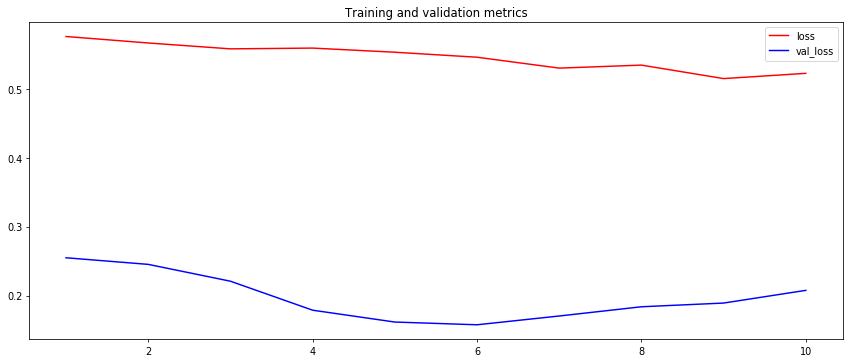

In [34]:
plot_train_validation_metric(history, 'loss', 'val_loss')

## We have 2984 positive and 984 negtive cases. 

In [14]:
#Make predictions for train set
    
X, Y = generator_to_samples_and_targets(train_gen, train_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 2920, 1.0: 984})
F1 score: 0.163636
precision score: 0.775862
recall score: 0.091463
accuracy score: 0.764344
matthews_corrcoef: 0.211116

Confusion matrix:
[[2894   26]
 [ 894   90]]


In [15]:
#Make predictions from dev set
X, Y = generator_to_samples_and_targets(val_gen, val_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

Counter({0.0: 821, 1.0: 11})
F1 score: 0.000000
precision score: 0.000000
recall score: 0.000000
accuracy score: 0.985577
matthews_corrcoef: -0.004015

Confusion matrix:
[[820   1]
 [ 11   0]]


In [ ]:
#Make predictions for test set
X, Y = generator_to_samples_and_targets(test_gen, test_steps)    
Y_pred = model.predict(X)
print(collections.Counter(Y))
print_report_for_binary_classfier(Y, probs_to_binary_classes(Y_pred))

# Save the best model

In [ ]:
from keras.models import load_model

model.save(params.BEST_MODEL_PATH)  # creates a HDF5 file 'my_model.h5'